In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [2]:
density_data = pd.read_csv("../Curated_data/density_predictors.csv", low_memory=False)


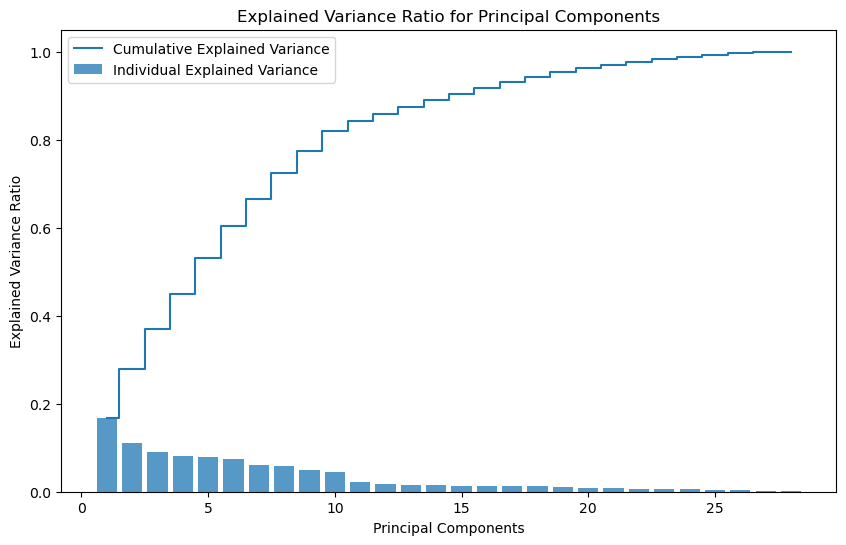

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
variables_of_interest = 'Density_gcm3'
# Extract features (excluding the variables to keep)
features = density_data.drop(columns=variables_of_interest)

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

#Fill NAs
features_filled = np.nan_to_num(features_standardized, nan=0)


# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(features_filled)

# Create a DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, len(features.columns)+1)])

# Plot the explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_
cumulative_explained_var = explained_var_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_var_ratio) + 1), explained_var_ratio, alpha=0.75, align='center', label='Individual Explained Variance')
plt.step(range(1, len(explained_var_ratio) + 1), cumulative_explained_var, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Principal Components')
plt.legend()
plt.show()


In [6]:
pc_df['Density_gcm3'] = density_data['Density_gcm3']

In [24]:
mineral = 'Density_gcm3'
pc_df = pc_df.dropna(subset=[mineral])

In [25]:
covariates = pc_df.iloc[:, :-1].columns
covariates = covariates[:10]
deposit_data = pc_df

In [26]:
np.random.seed(42)
torch.manual_seed(42)






x = deposit_data[covariates].values  # Use X, Y, and Z coordinates
y = deposit_data[mineral].values[:, np.newaxis]  # Keep mineral as the output
x = x.reshape(len(deposit_data), len(covariates))

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the unique 'Name' values
unique_names = deposit_data['Name'].unique()

# Initialize empty lists to store training and testing data
x_train = []
y_train = []
x_test = []
y_test = []

# Iterate through unique 'Name' values and assign each hole's data to either train or test
for name in unique_names:
    # Select data for the current hole
    hole_data = deposit_data[deposit_data['Name'] == name]
    x_hole = hole_data[['X', 'Y', 'Z']].values
    y_hole = hole_data['Density_gcm3'].values

    # Assign the hole's data to either train or test
    if np.random.rand() < 0.2:  # You can adjust the ratio, e.g., 0.2 for a 80/20 split
        x_test.extend(x_hole)
        y_test.extend(y_hole)
    else:
        x_train.extend(x_hole)
        y_train.extend(y_hole)

# Convert the lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


model = nn.Sequential(
    nn.Linear(in_features=3, out_features=500),
    nn.ReLU(),
    nn.Linear(in_features=500, out_features=1)
)

mse_loss = nn.MSELoss()
#Apparently lr=0.005 is better than 0.01 and than 0.001: quicker and better convergence
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(91):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 100 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.4f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.2)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.05)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.05 MSE')
plt.show()

# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.5 MSE')
plt.show()







# # Define a grid of points for prediction (including X, Y, and Z)
# x_grid = np.linspace(x[:, 0].min(), x[:, 0].max(), 50)
# y_grid = np.linspace(x[:, 1].min(), x[:, 1].max(), 50)
# z_grid = np.linspace(x[:, 2].min(), x[:, 2].max(), 50)
# xyz_grid = np.array(np.meshgrid(x_grid, y_grid, z_grid)).T.reshape(-1, 3)

# # Make predictions for the grid
# predictions = model(torch.tensor(xyz_grid, dtype=torch.float32))

# # Reshape the predictions to match the grid shape
# predictions = predictions.data.numpy().reshape(50, 50, 50)

# # Create a 3D surface plot using Plotly

# # Pool the values from predictions_hole and y_hole
# pooled_values = np.concatenate([predictions.ravel(), y_test.data.numpy()[:, 0]])

# # Determine the minimum and maximum values for the color mapping
# vmin = np.min(pooled_values)
# vmax = np.max(pooled_values)

# fig = go.Figure(data=[
#     go.Scatter3d(
#     x=xyz_grid[:,0],
#     y=xyz_grid[:,1],
#     z=xyz_grid[:,2],
#     mode='markers',
#     marker=dict(
#         size=4,
#         color=predictions.ravel(),
#         colorscale='viridis',  # Adjust the color scale
#         colorbar=dict(title=mineral),
#         opacity=0.7,
#         cmax=vmax,
#         cmin=vmin,
#     ),
#     name='Test set',
#     text = ["Density: {}".format(x) for x in predictions.ravel() ]

# )])


# # Add a scatter plot for test data points
# fig.add_trace(go.Scatter3d(
#     x=x_test.data.numpy()[:, 0],
#     y=x_test.data.numpy()[:, 1],
#     z=x_test.data.numpy()[:, 2],
#     mode='markers',
#     marker=dict(
#         size=4,
#         color=y_test.data.numpy().ravel(),
#         colorscale='viridis',  # Adjust the color scale
#         colorbar=dict(title=mineral),
#         opacity=0.7,
#         cmax=vmax,
#         cmin=vmin,
#     ),
#     name='Test set',
#     text = ["Density: {}".format(x) for x in y_test.data.numpy().ravel()]

# ))



# fig.update_layout(
#     scene=dict(
#         xaxis_title='X',
#         yaxis_title='Y',
#         zaxis_title='Z',
#         aspectmode='data',
#     ),
# )
# #fig.write_html('tmp.html', auto_open=True)
# #fig.show()




KeyError: 'Name'